In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [188]:
df = pd.read_csv('caixa.csv')
df = df.set_index('data')
df.index = pd.to_datetime(df.index, format='%d/%m/%Y %H:%M')

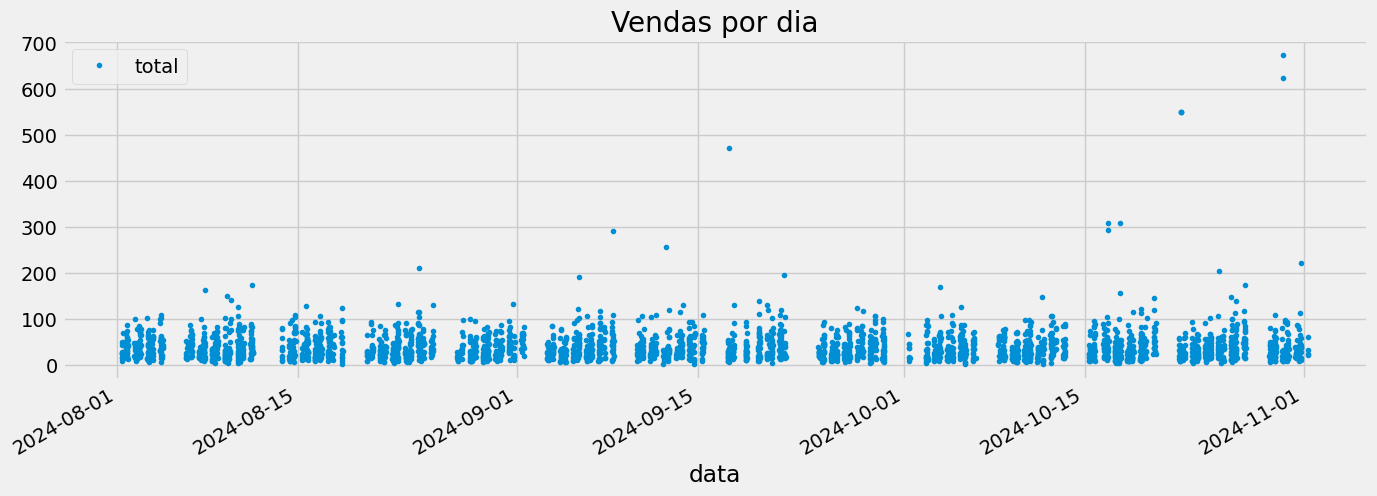

In [189]:
df.plot(style='.',
         figsize=(15, 5),
         title='Vendas por dia')
plt.show()

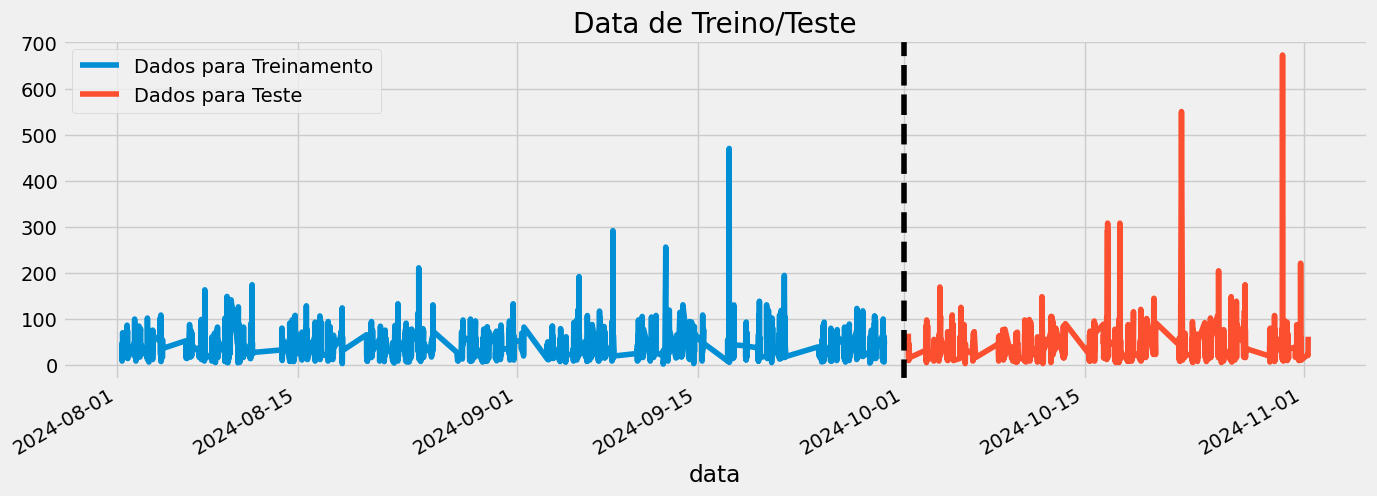

In [190]:
train = df.loc[df.index < '2024-10-01']
test = df.loc[df.index >= '2024-10-01']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Dados para Treinamento', title='Data de Treino/Teste')
test.plot(ax=ax, label='Dados para Teste')
ax.axvline('2024-10-01', color='black', ls='--')
ax.legend(['Dados para Treinamento', 'Dados para Teste'])
plt.show()

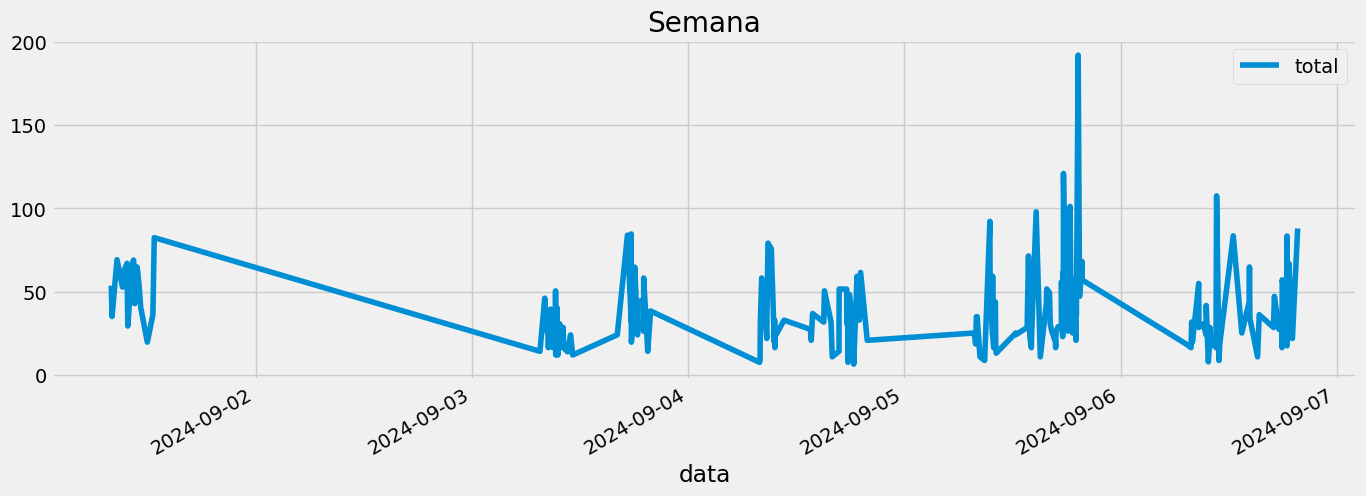

In [191]:
df.loc[(df.index > '2024-9-01') & (df.index < '2024-9-07')] \
    .plot(figsize=(15, 5), title='Semana')
plt.show()

In [192]:
def create_features(df):
    # Chama papai
    df = df.copy() 

    df['hora'] = df.index.hour
    df['diaSemana'] = df.index.day_of_week
    df['mes'] = df.index.month
    
    #df['dia_do_ano'] = df.index.dayofyear 

    return df

df = create_features(df)

In [193]:
df.columns

Index(['total', 'hora', 'diaSemana', 'mes'], dtype='object')

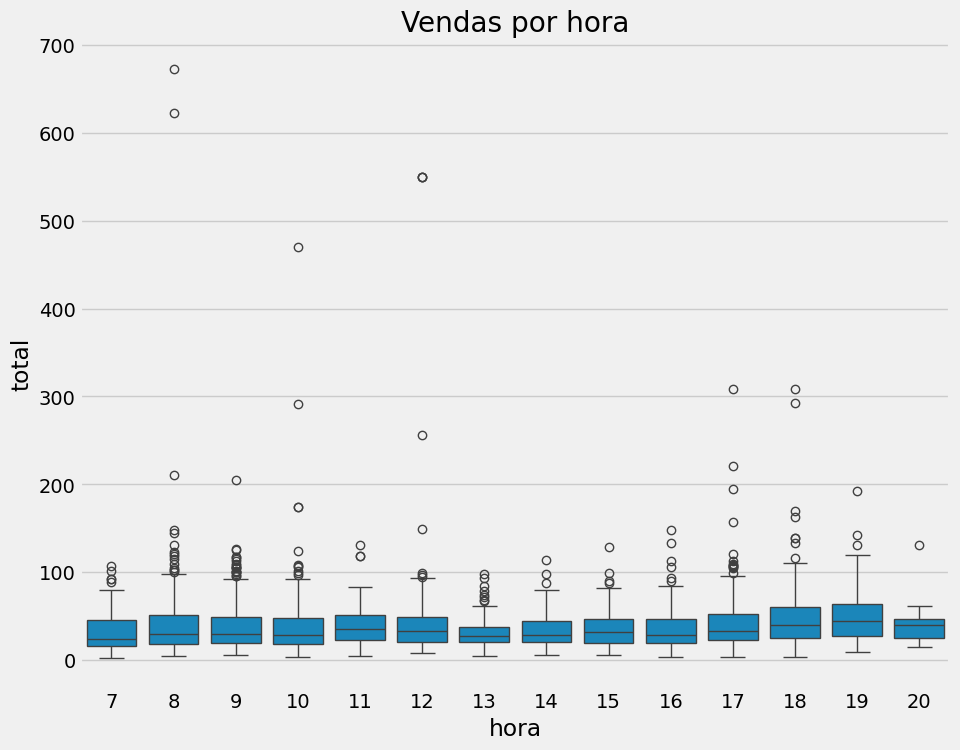

In [194]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hora', y='total')
ax.set_title('Vendas por hora')
plt.show()

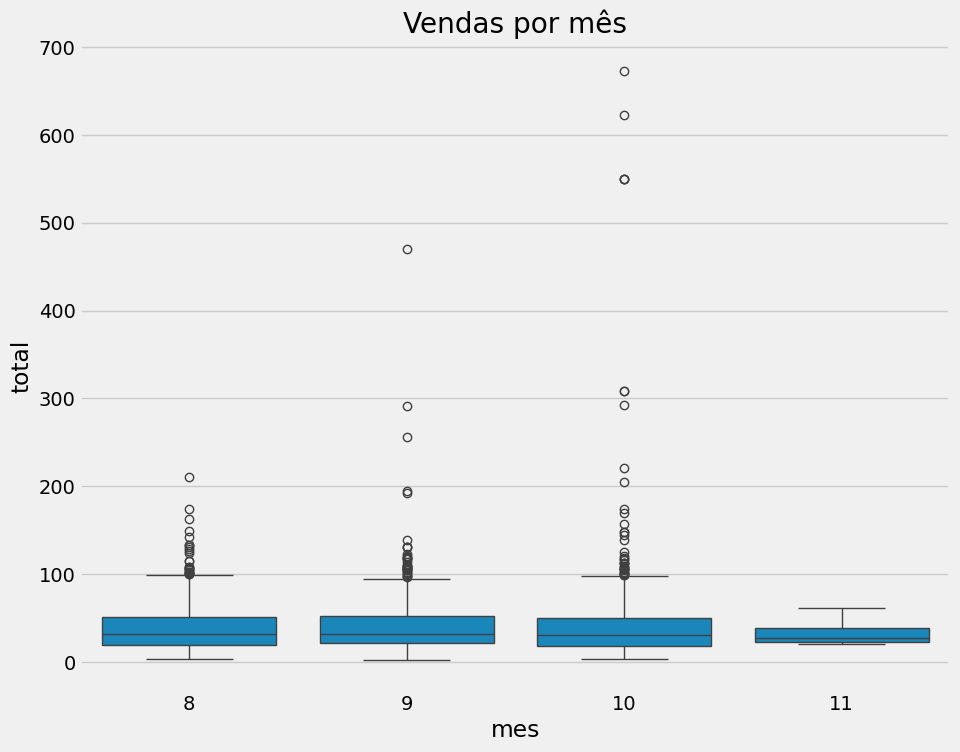

In [195]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='mes', y='total')
ax.set_title('Vendas por mês')
plt.show()

In [196]:
df.columns

Index(['total', 'hora', 'diaSemana', 'mes'], dtype='object')

In [197]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hora', 'mes' , 'diaSemana']
TARGET = 'total'

X_train =  train[FEATURES]
y_train =  train[TARGET]

X_test =  test[FEATURES]
y_test =  test[TARGET]

In [198]:
reg = xgb.XGBRegressor (n_estimators=1000, early_stopping_rounds = 50, learning_rate=0.1)
reg.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_test, y_test)],
        verbose=True)

[0]	validation_0-rmse:27.45516	validation_1-rmse:46.10836
[1]	validation_0-rmse:27.23638	validation_1-rmse:46.06516
[2]	validation_0-rmse:27.05935	validation_1-rmse:46.04689
[3]	validation_0-rmse:26.90974	validation_1-rmse:46.03110
[4]	validation_0-rmse:26.78895	validation_1-rmse:46.02226
[5]	validation_0-rmse:26.68985	validation_1-rmse:46.02123
[6]	validation_0-rmse:26.60432	validation_1-rmse:46.03433
[7]	validation_0-rmse:26.53336	validation_1-rmse:46.04233
[8]	validation_0-rmse:26.47269	validation_1-rmse:46.06288
[9]	validation_0-rmse:26.42586	validation_1-rmse:46.07346
[10]	validation_0-rmse:26.38047	validation_1-rmse:46.09126
[11]	validation_0-rmse:26.34052	validation_1-rmse:46.11808
[12]	validation_0-rmse:26.30903	validation_1-rmse:46.13389
[13]	validation_0-rmse:26.27768	validation_1-rmse:46.15713
[14]	validation_0-rmse:26.25751	validation_1-rmse:46.17405
[15]	validation_0-rmse:26.22384	validation_1-rmse:46.20035
[16]	validation_0-rmse:26.20271	validation_1-rmse:46.22612
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

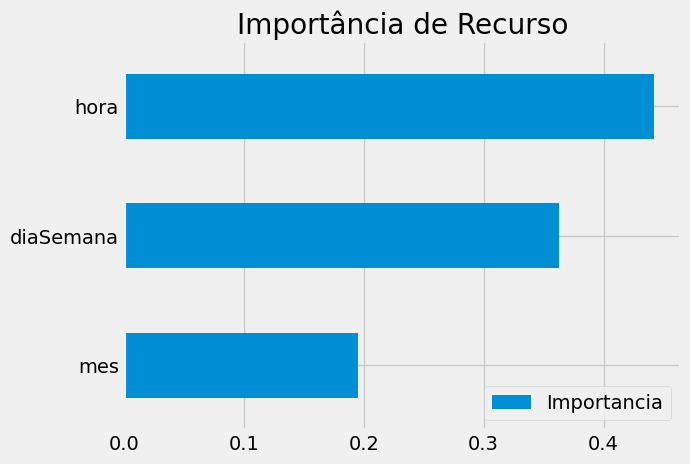

In [199]:
#Importância do recurso (ajuda a identificar quais features nos dados são mais influentes)

fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['Importancia'])
fi.sort_values('Importancia').plot(kind='barh', title='Importância de Recurso')
plt.show()


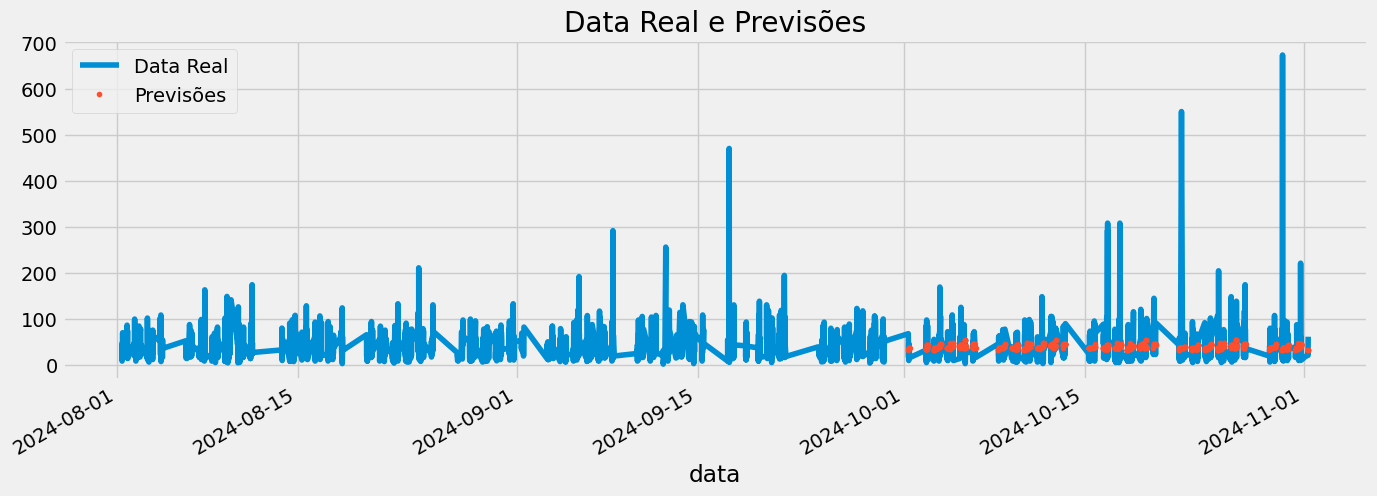

In [200]:
test['previsao'] = reg.predict(X_test)
df = df.merge(test[['previsao']], how='left', left_index=True, right_index=True)
ax = df[['total']].plot(figsize=(15, 5))
df['previsao'].plot(ax=ax, style='.')
plt.legend(['Data Real', 'Previsões'])
ax.set_title('Data Real e Previsões')
plt.show()

In [201]:
score = np.sqrt(mean_squared_error(test['total'], test['previsao']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 46.02


In [205]:
test['error'] = np.abs(test[TARGET] - test['previsao'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2024-10-22    54.435782
2024-10-30    40.382093
2024-10-16    28.728777
2024-10-20    25.441900
2024-10-02    24.570997
2024-10-26    23.872946
2024-10-19    22.382892
2024-10-17    22.327102
2024-10-27    21.737150
2024-10-31    21.211911
Name: error, dtype: float64